In [1]:
# Load and explore the Telco Customer Churn dataset, then produce a concise EDA and baseline models

# 1) Imports and file read
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read from local working directory copy (the file is available here as per system metadata)
file_path_local = r"C:\Users\FrankJR\Downloads\Portfolio\Telco Customer Churn\Telco Customer Churn.csv"
df_telco = pd.read_csv(file_path_local, encoding='ascii')
print('Loaded dataset shape:')
print(df_telco.shape)
print('Columns:')
print(list(df_telco.columns))
print('Head:')
print(df_telco.head())

Loaded dataset shape:
(7043, 21)
Columns:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Head:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               N

In [2]:
# 2) Basic cleaning: ensure numeric types
# TotalCharges sometimes has spaces in some versions; coerce to numeric
if 'TotalCharges' in df_telco.columns:
    df_telco['TotalCharges'] = pd.to_numeric(df_telco['TotalCharges'], errors='coerce')

# Report missing values
missing_counts = df_telco.isna().sum().sort_values(ascending=False)
print('Missing values per column:')
print(missing_counts.head(10))

# Drop rows with missing critical numeric fields (very few in this dataset)
df_clean = df_telco.dropna(subset=['TotalCharges'])
print('Post-clean shape (dropna on TotalCharges):')
print(df_clean.shape)

Missing values per column:
TotalCharges      11
gender             0
SeniorCitizen      0
Partner            0
customerID         0
Dependents         0
tenure             0
MultipleLines      0
PhoneService       0
OnlineSecurity     0
dtype: int64
Post-clean shape (dropna on TotalCharges):
(7032, 21)


In [3]:
# 3) Quick target overview
print('Churn distribution:')
print(df_clean['Churn'].value_counts(normalize=True).rename('proportion'))

Churn distribution:
Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


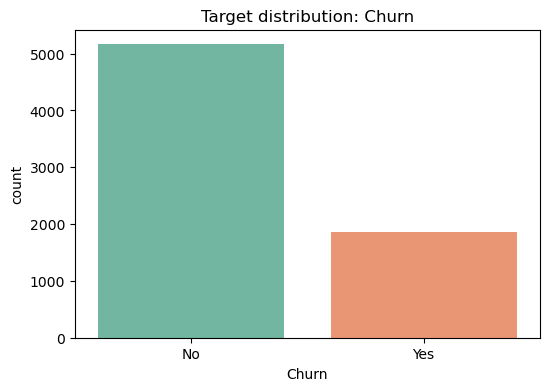

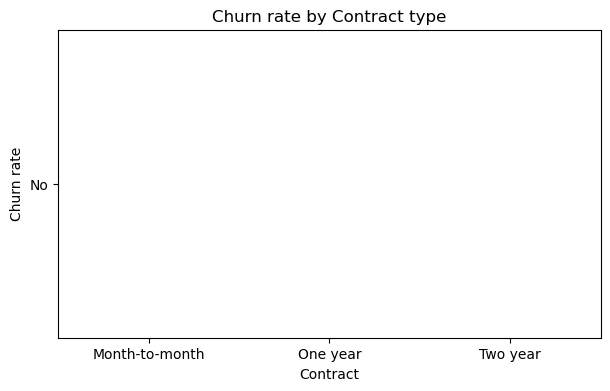

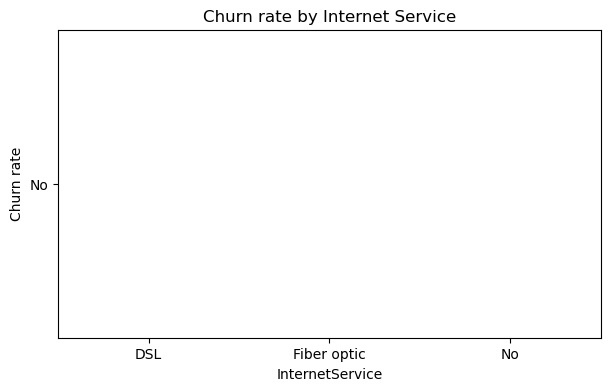

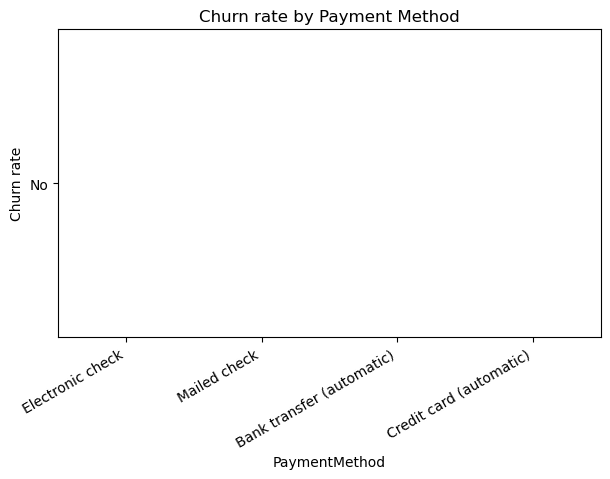

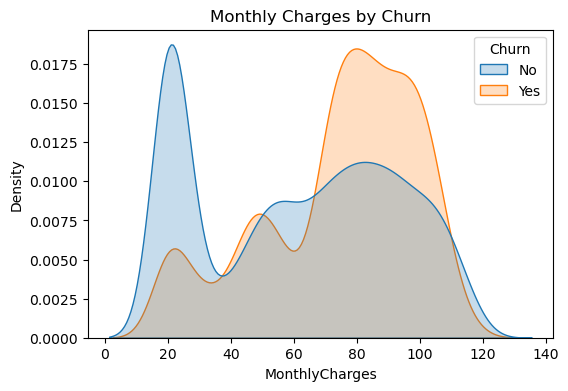

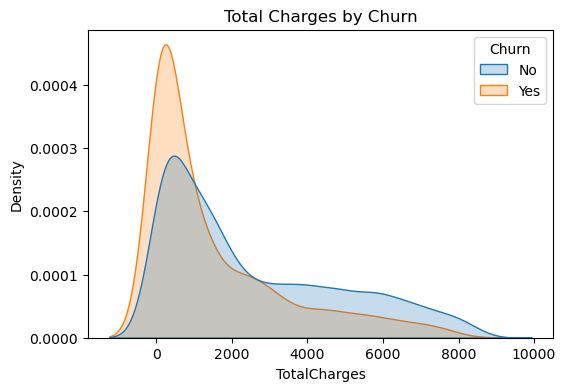

In [4]:
# 4) Visuals: churn rate by key categorical features
plt.figure(figsize=(6,4))
sns.countplot(data=df_clean, x='Churn', hue='Churn', palette='Set2', legend=False)
plt.title('Target distribution: Churn')
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=df_clean, x='Contract', y='Churn', hue='Contract', 
            estimator=lambda x: np.mean(x == 'Yes'), errorbar=None, palette='Set3', legend=False)
plt.title('Churn rate by Contract type')
plt.ylabel('Churn rate')
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=df_clean, x='InternetService', y='Churn', hue='InternetService', 
            estimator=lambda x: np.mean(x == 'Yes'), errorbar=None, palette='Set3', legend=False)
plt.title('Churn rate by Internet Service')
plt.ylabel('Churn rate')
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=df_clean, x='PaymentMethod', y='Churn', hue='PaymentMethod', 
            estimator=lambda x: np.mean(x == 'Yes'), errorbar=None, palette='Set3', legend=False)
plt.title('Churn rate by Payment Method')
plt.ylabel('Churn rate')
plt.xticks(rotation=30, ha='right')
plt.show()

# Numeric relationships
plt.figure(figsize=(6,4))
sns.kdeplot(data=df_clean, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False)
plt.title('Monthly Charges by Churn')
plt.show()

plt.figure(figsize=(6,4))
sns.kdeplot(data=df_clean, x='TotalCharges', hue='Churn', fill=True, common_norm=False)
plt.title('Total Charges by Churn')
plt.show()

In [5]:
# 5) Feature engineering and encoding for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define features and target
X = df_clean.drop(columns=['customerID', 'Churn'])
y = df_clean['Churn'].map({'No': 0, 'Yes': 1})

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print('Categorical columns:')
print(cat_cols[:10])
print('Numeric columns:')
print(num_cols)

# Preprocess - add scaling for numeric features to help logistic regression converge
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numeric_transformer = StandardScaler()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numeric_transformer, num_cols)
    ]
)

Categorical columns:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
Numeric columns:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [6]:
# 6) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train/Test sizes:')
print(X_train.shape)
print(X_test.shape)

Train/Test sizes:
(5625, 19)
(1407, 19)


In [7]:
# 7) Baseline models - increased max_iter for LogisticRegression and added solver
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced_subsample')
}

results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {
        'auc': auc,
        'report': classification_report(y_test, y_pred, output_dict=False),
        'cm': confusion_matrix(y_test, y_pred)
    }
    print('Trained model:')
    print(name)
    print('AUC:')
    print(auc)
    print('Classification Report:')
    print(results[name]['report'])

Trained model:
LogisticRegression
AUC:
0.8351137075440931
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407

Trained model:
RandomForest
AUC:
0.8145956173545718
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



<Figure size 600x500 with 0 Axes>

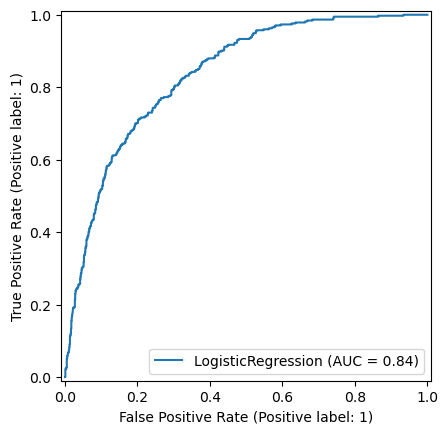

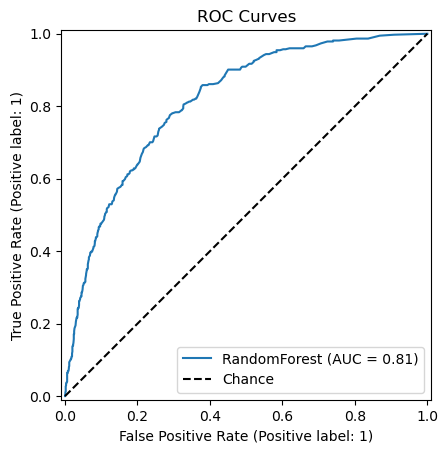

In [8]:
# 8) Plot ROC curves
plt.figure(figsize=(6,5))
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)
plt.plot([0,1],[0,1],'k--', label='Chance')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [9]:
# 9) Save a concise portfolio-ready summary text
summary_lines = []
summary_lines.append('Project: Telco Customer Churn Prediction')
summary_lines.append('Objective: Analyze drivers of churn and build baseline predictive models.')
summary_lines.append('Data: ' + str(df_clean.shape[0]) + ' customers, ' + str(df_clean.shape[1]) + ' columns after cleaning.')
churn_rate = y.mean()
summary_lines.append('Churn rate: ' + str(round(float(churn_rate), 3)))
summary_lines.append('Key signals observed:')
summary_lines.append('- Month-to-month contracts and Electronic check payments show higher churn rates.')
summary_lines.append('- Higher MonthlyCharges correlate with higher churn; longer-tenure customers churn less as reflected in TotalCharges distribution.')
summary_lines.append('Models and performance:')
for name in results:
    summary_lines.append('- ' + name + ' AUC: ' + str(round(float(results[name]['auc']), 3)))
portfolio_text = '\n'.join(summary_lines)

with open('telco_churn_portfolio_summary.txt', 'w') as f:
    f.write(portfolio_text)

print('Saved portfolio summary to:')
print('telco_churn_portfolio_summary.txt')
print('Done initial EDA and baseline modeling.')

Saved portfolio summary to:
telco_churn_portfolio_summary.txt
Done initial EDA and baseline modeling.
